# Analytics for IF neurons driven by ecitatory shot noise - Examples

In [1]:
%matplotlib inline

import analytics.shot_noise_driven.lif_neuron as snlif  # analytics for LIF neurons driven by SN
import analytics.shot_noise_driven.if_neuron as snif # analytics for general IF neurons driven by SN
import analytics.gaussian_white_noise_driven.lif_neuron as dalif
import analytics.gaussian_white_noise_driven.if_neuron as daif
import numpy as np
import pylab as pl

## Firing rate

Functions in the analytics module enforce the use of named parameters. This makes it easier to understand what is going on, avoids bugs due to a wrong order of parameters, and allows to give feedback about missing parameters. 
E.g. the following call to calculate the firing rate of a leaky integrate-and-fire neuron (LIF) is missing parameters:

In [2]:
try:
    snlif.r0(mu=0.1, vr=0, a_e=0.15)
except TypeError as e:
    print e

r0 is missing arguments: 'rin_e','vt','tr'


If instead we supply all of them:

In [3]:
snlif.r0(mu=0.1, rin_e=17.6, a_e=0.15, vr=0, vt=1, tr=0.1)

1.660220667961072

Note that for all of the supplied functions, time is measured in units of the membrane time constant. For a membrane time constant of 20ms, the above corresponds to:

In [4]:
tau = 0.02 # s
rin_si = 880 # Hz
tr_si = 0.002 # s
print "r0 = %g Hz" % (snlif.r0(mu=0.1, rin_e=rin_si*tau, a_e=0.15, vr=0, vt=1, tr=tr_si/tau) / tau)

r0 = 83.011 Hz


The provided functions also accept one non-keyword argument, which is interpreted as a dictionary with default parameters:

In [5]:
prms = {"mu": 0.1, "rin_e": 17.6, "a_e": 0.15, "vr": 0, "vt": 1, "tr": 0.1}
snlif.r0(prms)

1.660220667961072

When a parameter dict is passed, individual parameters can still be overwritten:

In [6]:
snlif.r0(prms, tr=0.2, mu=-0.5)

1.1583099022343237

The firing rate can also be calculated using the functions for general IF neurons:

In [7]:
snif.r0(prms, model=snif.LIF())

1.6602206679610714

Obviously, the result is different if we use a different neuron model, e.q. the quadratic integrate-and-fire (QIF) neuron:

In [8]:
snif.r0(prms, model=snif.QIF())

2.129546663431224

The model can also be an EIF, for which we need to supply an "effective" threshold vtb and the spike onset parameter d. Compared to PIF, LIF, and QIF, evaluating the anayltics for an EIF entails one more numerical integration. To speed this up, we rely on a small C library that implements the integrand. Let's see if this is present..

In [9]:
if snif.eiflib is not None:
    print ":) library present, r0 = %g" %snif.r0(prms, model=snif.EIF(vtb=1.0, d=0.5), vt=10)
else:
    import os
    print ":( library not present. You probably need to go to %s and compile it, using e.g. %s)" % (os.path.dirname(snif.eiflibpath), "cc -fPIC -O2 --shared -o libeif_phi.so eif_phi.c")

:) library present, r0 = 0.969802


Finally, let's compare the firing rate of a shot-noise-driven perfect integrator (PIF) to the diffusion approximation (DA) for different mean spike weights

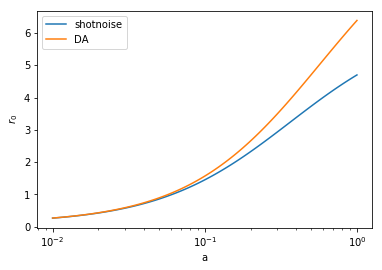

In [10]:
def mueff(mu, rin_e, a_e):
    return mu  + rin_e*a_e

def Deff(rin_e, a_e):
    return a_e**2 * rin_e

a_es = np.logspace(-2,0,100)

pl.plot(a_es, [snif.r0(prms, model=snif.PIF(), a_e=a_e) for a_e in a_es], label="shotnoise")
pl.plot(a_es, [daif.r0(prms, model=daif.PIF(), mu=mueff(prms["mu"], prms["rin_e"], a_e), D=Deff(prms["rin_e"], a_e)) for a_e in a_es], label="DA")
pl.xlabel("a")
pl.ylabel("$r_0$")
pl.xscale("log")
pl.legend();

## Stationary voltage distribution

We first define the voltage axis:

In [11]:
vs = np.linspace(-0.2, 1, 100)

We plot the stationary probability density $P_0(v)$ for $\mu > v_T$ and $\mu < v_T$. One can see that the density at the threshold is only non-vanishing if trajectories can cross the threshold even between input spikes (by drifting)... 

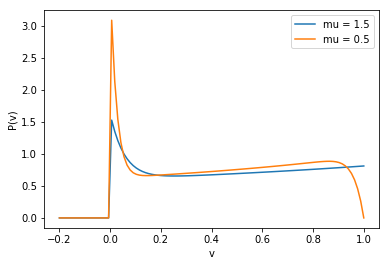

In [12]:
pl.plot(vs, [snif.P0(prms, model=snif.LIF(), v=v, mu=1.5) for v in vs], label="mu = 1.5")
pl.plot(vs, [snif.P0(prms, model=snif.LIF(), v=v, mu=0.5) for v in vs], label="mu = 0.5")
pl.xlabel("v")
pl.ylabel("P(v)")
pl.legend();

This can be quantified by looking at $\alpha$, the fraction of trajectories that cross the threshold due to input spikes:

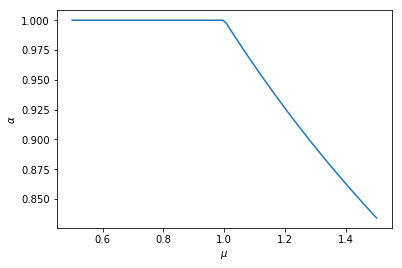

In [13]:
mus = np.linspace(0.5, 1.5, 100)
pl.plot(mus, [snif.alpha(prms, model=snif.LIF(), mu=mu) for mu in mus])
pl.xlabel(r"$\mu$")
pl.ylabel(r"$\alpha$");

For a perfect integrate-and-fire (PIF), there is no leak term, so the two regimes are above or below $\mu = 0$, respectively:

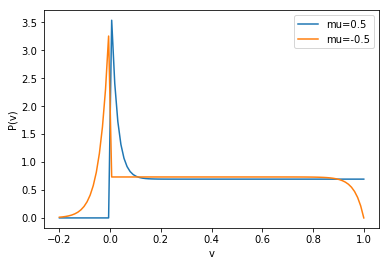

In [14]:
pl.plot(vs, [snif.P0(prms, model=snif.PIF(), v=v, mu=0.5) for v in vs], label="mu=0.5")
pl.plot(vs, [snif.P0(prms, model=snif.PIF(), v=v, mu=-0.5) for v in vs], label="mu=-0.5")
pl.xlabel("v")
pl.ylabel("P(v)")
pl.legend();

## Power spectrum and susceptibility

The spectral quantities are expressed in terms of (confluent) hypergeometric functions. The only library I found (in either C/C++ or Python) that supports these with complex-valued arguments is mpmath, which is excellent but not too fast. We thus provide a small C library and its Python interface in analytics.specfunc. To make it available to the analytics implementations, it needs to be compiled. Let's see whether this has already happened...

In [15]:
import analytics.specfunc as sf
if sf.lib is None:
    msg = """Library not loaded, you probably need to go to %s 
and compile it (e.g: cc -fPIC -O2 --shared -o libspecfunc.so specfunc.c).
Until then, I fall back to the mpmath implementation"""
    print msg % sf.libdir
else:
    print "Library has been loaded :)"

Library has been loaded :)


The frequency range to be considered (including 0 would give division-by-zero issues):

In [16]:
fs = np.linspace(1e-4, 10, 500)

Let's look at power spectra for different input rate/avg. spike weight combinations:

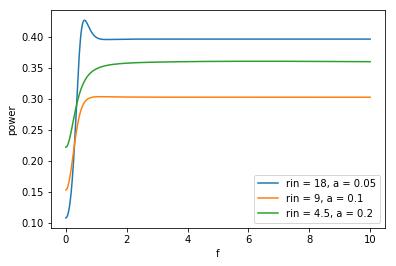

In [17]:
pl.plot(fs, snlif.powspec(prms, fs=fs, rin_e=18.0, a_e=0.05), label="rin = 18, a = 0.05")
pl.plot(fs, snlif.powspec(prms, fs=fs, mu=-0.1, rin_e=9, a_e=0.1), label="rin = 9, a = 0.1")
pl.plot(fs, snlif.powspec(prms, fs=fs, mu=-0.1, rin_e=4.5, a_e=0.2), label="rin = 4.5, a = 0.2")
pl.xlabel("f")
pl.ylabel("power")
pl.legend();

The power spectrum of a shot-noise-driven IF neuron vs the diffusion approximation (the implementation of the DA-spectral quantities is quite small, due to the lack of efficient implementations for the parabolic cylinder functions):

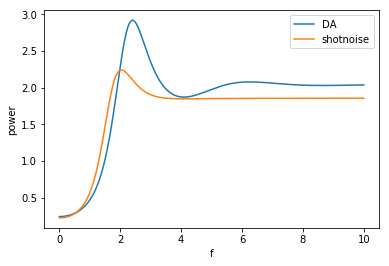

In [18]:
pl.plot(fs, dalif.powspec(prms, fs=fs, mu=mueff(0.5, 25.0, 0.1), D=Deff(25.0, 0.1)), label="DA")
pl.plot(fs, snlif.powspec(prms, fs=fs, mu=0.5, rin_e=25.0, a_e=0.1), label="shotnoise")
pl.xlabel("f")
pl.ylabel("power")
pl.legend();

And the same for the susceptibility (the firing rate response) to a current signal:

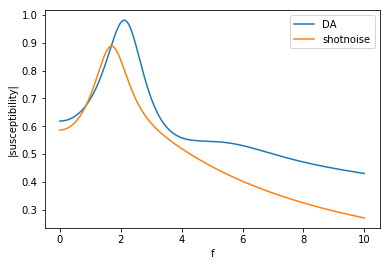

In [19]:
pl.plot(fs, np.abs(dalif.suscep(prms, fs=fs, mu=mueff(0.5, 25.0, 0.1), D=Deff(25.0, 0.1))), label="DA")
pl.plot(fs, np.abs(snlif.suscep(prms, fs=fs, mu=0.5, rin_e=25.0, a_e=0.1)), label="shotnoise")
pl.xlabel("f")
pl.ylabel("|susceptibility|")
pl.legend();